<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 8
<br>
<b>Deadline:</b> March 31, 2021 (Wednesday) 23:00
</div>

# Exercise 5. Sequence-to-sequence modeling with recurrent neural networks

The goals of this exercise are
* to get familiar with recurrent neural networks used for sequential data processing
* to get familiar with the sequence-to-sequence model for machine translation
* to learn PyTorch tools for batch processing of sequences with varying lengths
* to learn how to write a custom `DataLoader`

You may find it useful to look at this tutorial:
* [Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

The dataset that we are going to use consists of pairs of sentences in French and English.

In [7]:
from data import TranslationDataset, MAX_LENGTH, SOS_token, EOS_token

trainset = TranslationDataset(data_dir, train=True)

* `TranslationDataset` supports indexing as required by `torch.utils.data.Dataset`.
* Sentences are tensors of maximum length `MAX_LENGTH`.
* Words in a (sentence) tensor are represented as an index (integer) in a language vocabulary.
* The string representation of a word from the source language can be obtained from index `i` with `dataset.input_lang.index2word[i]`.
* Similarly for the target language `dataset.output_lang.index2word[j]`.

Let us look at samples from that dataset.

In [8]:
src_sentence, tgt_sentence = trainset[np.random.choice(len(trainset))]
print('Source sentence: "%s"' % ' '.join(trainset.input_lang.index2word[i.item()] for i in src_sentence))
print('Sentence as tensor of word indices:')
print(src_sentence)

print('Target sentence: "%s"' % ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_sentence))
print('Sentence as tensor of word indices:')
print(tgt_sentence)

Source sentence: "je suis satisfaite de sa prestation . EOS"
Sentence as tensor of word indices:
tensor([   6,   11,  682,  101, 2310, 4100,    5,    1])
Target sentence: "i m pleased with his performance . EOS"
Sentence as tensor of word indices:
tensor([   2,    3,  907,  691,  599, 2604,    4,    1])


In [9]:
print('Number of source-target pairs in the training set: ', len(trainset))

Number of source-target pairs in the training set:  8682


## Sequence-to-sequence model for machine translation

In this exercise, we are going to build a machine translation system which transforms a sentence in one language into a sentence in another one. The computational graph of the translation model is shown below:

<img src="seq2seq.png" width=900>

We are going to use a simplified model without the dotted connections.

## Custom DataLoader

We would like to train the sequence-to-sequence model using mini-batch training.
One difficulty of mini-batch training in this case is that sequences may have varying lengths and this has to be taken into account when building the computational graph. Luckily, PyTorch has tools to support batch processing of such sequences.
To use those tools, we need to write a custom data loader which puts sequences of varying lengths in the same tensor. We can customize the data loader by providing a custom `collate_fn` as explained [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Our collate function:
- combines sequences from the source language in a single tensor with extra values (at the end) filled with `PADDING_VALUE=0`.
- combines sequences from the target language in a single tensor with extra values (at the end) filled with `PADDING_VALUE=0`.

**Important**:
- Later in the code (not in this `collate` function), we will convert source sequences to objects of class [`PackedSequence`](https://pytorch.org/docs/stable/nn.html?highlight=packedsequence#torch.nn.utils.rnn.PackedSequence) which can be processed by recurrent units such as `GRU` or `LSTM`. Conversion to `PackedSequence` objects requires sequences to be sorted by their lengths.
**Therefore, the returned source sequences should be sorted by length in a decreasing order.**
* The target sequences need not be sorted by their lengths because we have to keep the same order of sequences in the source and target tensors.

Your task is to implement the collate function.

In [10]:
PADDING_VALUE = 0

In [11]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_seq):
          src_seq is of shape (src_seq_length,)
          tgt_seq is of shape (tgt_seq_length,)

    Returns:
      src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
          The sequences should be sorted by length in a decreasing order, that is src_seqs[:,0] should be
          the longest sequence, and src_seqs[:,-1] should be the shortest.
      src_seq_lengths: List of lengths of source sequences.
      tgt_seqs of shape (max_tgt_seq_length, batch_size): Tensor of padded target sequences.
    """
    list_of_samples.sort(key=lambda x: len(x[0]), reverse=True)
    
    data = [item[0] for item in list_of_samples]
    target = [item[1] for item in list_of_samples]
    lengths = [item.shape[0] for item in data]
    data = pad_sequence(data, padding_value=PADDING_VALUE)
    target = pad_sequence(target, padding_value=PADDING_VALUE)
    
    return data, lengths, target

In [12]:
def test_collate_shapes():
    pairs = [
        (torch.LongTensor([1, 2]), torch.LongTensor([3, 4, 5])),
        (torch.LongTensor([6, 7, 8]), torch.LongTensor([9, 10])),
    ]
    pad_src_seqs, src_seq_lengths, pad_tgt_seqs = collate(pairs)
    assert type(src_seq_lengths) == list, "src_seq_lengths should be a list."
    assert pad_src_seqs.shape == torch.Size([3, 2]), f"Bad pad_src_seqs.shape: {pad_src_seqs.shape}"
    assert pad_src_seqs.dtype == torch.long
    assert pad_tgt_seqs.shape == torch.Size([3, 2]), f"Bad pad_tgt_seqs.shape: {pad_tgt_seqs.shape}"
    assert pad_tgt_seqs.dtype == torch.long
    print('Success')

test_collate_shapes()

Success


In [13]:
# This cell tests collate() function

In [14]:
# We create custom DataLoader using the implemented collate function
# We are going to process 64 sequences at the same time (batch_size=64)
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

## Encoder

The encoder encodes a source sequence $(x_1, x_2, ..., x_T)$ into a single vector $h_T$ using the following recursion:
$$
  h_{t} = f(h_{t-1}, x_t) \qquad t = 1, \ldots, T
$$
where:
* intial state $h_0$ is often chosen arbitrarily (we choose it to be zero)
* function $f$ is defined by the type of the RNN cell (in our experiments, we will use [GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU))
* $x_t$ is a vector that represents the $t$-th word in the source sentence.

A common practice in natural language processing is to _learn_ the word representations $x_t$ (instead of, for example, using one-hot coded vectors). In PyTorch, this is supported by class [Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding) which we are going to use.

The computational graph of the encoder is shown below:

<img src="seq2seq_encoder.png" width=500>

Your task is to implement the `forward` function of the encoder. It should contain the following steps:
* Embed the words of the source sequences.
* Pack source sequences using [`pack_padded_sequence`](https://pytorch.org/docs/stable/nn.html?highlight=pack_padded_sequence#torch.nn.utils.rnn.pack_padded_sequence). This converts padded source sequences into an object that can be processed by PyTorch recurrent units such as `nn.GRU` or `nn.LSTM`.
* Apply GRU computations to packed sequences obtained in the previous step
* Convert packed sequence of GRU outputs into padded representation with [`pad_packed_sequence`](https://pytorch.org/docs/stable/nn.html?highlight=pad_packed_sequence#torch.nn.utils.rnn.pad_packed_sequence).

In [15]:
class Encoder(nn.Module):
    def __init__(self, src_dictionary_size, embed_size, hidden_size):
        """
        Args:
          src_dictionary_size: The number of words in the source dictionary.
          embed_size: The number of dimensions in the word embeddings.
          hidden_size: The number of features in the hidden state of GRU.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(src_dictionary_size, embed_size)
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden_size)

    def forward(self, pad_seqs, seq_lengths, hidden):
        """
        Args:
          pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
          seq_lengths: List of sequence lengths.
          hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

        Returns:
          outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """    
        embedded = self.embedding(pad_seqs)
        packed = pack_padded_sequence(embedded, seq_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = pad_packed_sequence(outputs)
        return outputs, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [16]:
def test_Encoder_shapes():
    hidden_size = 3
    encoder = Encoder(src_dictionary_size=5, embed_size=10, hidden_size=hidden_size)

    max_seq_length = 4
    batch_size = 2
    hidden = encoder.init_hidden(batch_size=batch_size)
    pad_seqs = torch.tensor([
        [        1,             2],
        [        2,     EOS_token],
        [        3, PADDING_VALUE],
        [EOS_token, PADDING_VALUE]
    ])

    outputs, new_hidden = encoder.forward(pad_seqs=pad_seqs, seq_lengths=[4, 2], hidden=hidden)
    assert outputs.shape == torch.Size([4, batch_size, hidden_size]), f"Bad outputs.shape: {outputs.shape}"
    assert new_hidden.shape == torch.Size([1, batch_size, hidden_size]), f"Bad new_hidden.shape: {new_hidden.shape}"
    print('Success')

test_Encoder_shapes()

Success


In [17]:
# This cell tests Encoder

## Decoder

The decoder takes as input the representation computed by the encoder and transforms it into a sentence in the target language. The computational graph of the decoder is shown below:

<img src="seq2seq_decoder.png" width=500 align="top">

* $z_0$ is the output of the encoder, that is $z_0 = h_5$, thus `hidden_size` of the decoder should be the same as `hidden_size` of the encoder.
* $y_{i}$ are the log-probabilities of the words in the target language, the dimensionality of $y_{i}$ is the size of the target dictionary.
* $z_{i}$ is mapped to $y_{i}$ using a linear layer `self.out` followed by `F.log_softmax` (because we use `nn.NLLLoss` loss for training).
* Each cell of the decoder is a GRU, it receives as inputs the previous state $z_{i-1}$ and relu of the **embedding** of the previous word. Thus, you need to embed the words of the target language as well. The previous word is taken as the word with the maximum log-probability.

Note that the decoder outputs a word at every step and the same word is used as the input to the recurrent unit at the next step. At the beginning of decoding, the previous word input is fed with a special word SOS which stands for "start of a sentence". During training, we know the target sentence for decoding, therefore we can feed the correct words $y_i$ as inputs to the recurrent unit.

There is one extra thing that it is wise to take care of. When the target sentence is fed to the decoder during training, the decoder learns to generate only the next word (this scenario is called "teacher forcing"). At test time, the decoder works differently: it generates the whole sequence using its own predictions as inputs at each step. Therefore, it makes sense to train the decoder to produce full sentences. In order to do that, we will alternate between two modes during training:
* "teacher forcing": the decoder is fed with the words in the target sequence
* no "teacher forcing": the decoder generates the output sequence using its own predictions. In this case, we will generate sequences of the same length as the length of the longest sequence in `pad_tgt_seqs` (if `pad_tgt_seqs` is not `None`) or of length `MAX_LENGTH` (if `pad_tgt_seqs` is `None`).

You need to implement the decoder which has the structure shown in the figure above.

Notes:
* `SOS_token` is imported at the beginning of the notebook.
* **Running this code on GPU sometimes fails producing a CUDA error (if you know the reason, please let us know).** If this happens to you, please train the model on CPU.

In [18]:
class Decoder(nn.Module):
    def __init__(self, tgt_dictionary_size, embed_size, hidden_size):
        """
        Args:
          tgt_dictionary_size: The number of words in the target dictionary.
          embed_size: The number of dimensions in the word embeddings.
          hidden_size: The number of features in the hidden state.
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(tgt_dictionary_size, embed_size)
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, tgt_dictionary_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, hidden, pad_tgt_seqs=None, teacher_forcing=False):
        """
        Args:
          hidden of shape (1, batch_size, hidden_size): States of the GRU.
          pad_tgt_seqs of shape (max_out_seq_length, batch_size): Tensor of words (word indices) of the
              target sentence. If None, the output sequence is generated by feeding the decoder's outputs
              (teacher_forcing has to be False).
          teacher_forcing (bool): Whether to use teacher forcing or not.

        Returns:
          outputs of shape (max_out_seq_length, batch_size, tgt_dictionary_size): Tensor of log-probabilities
              of words in the target language.
          hidden of shape (1, batch_size, hidden_size): New states of the GRU.

        Note: Do not forget to transfer tensors that you may want to create in this function to the device
        specified by `hidden.device`.
        """
        
        output_len = MAX_LENGTH
        
        if pad_tgt_seqs is None:
            assert not teacher_forcing, 'Cannot use teacher forcing without a target sequence.'
        else:
            output_len = pad_tgt_seqs.shape[0]
        
        x = torch.LongTensor([[SOS_token]* hidden.size(1)], device=hidden.device)

        outs = torch.Tensor()
        for i in range(output_len):
            output = self.embedding(x)
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            output = self.out(hidden)
            output = self.softmax(output)
            outs = torch.cat((outs, output), 0)
            
            if teacher_forcing:
                x = pad_tgt_seqs[i].unsqueeze(0)
            else:
                topv, topi = output[0,:].topk(1)
                x = topi.squeeze().detach().unsqueeze(0)

        return outs, hidden
    
    def init_hidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [19]:
def test_Decoder_shapes():
    hidden_size = 2
    tgt_dictionary_size = 5
    test_decoder = Decoder(tgt_dictionary_size, embed_size=10, hidden_size=hidden_size)

    max_seq_length = 4
    batch_size = 2
    pad_tgt_seqs = torch.tensor([
        [        1,             2],
        [        2,     EOS_token],
        [        3, PADDING_VALUE],
        [EOS_token, PADDING_VALUE]
    ])  # [max_seq_length, batch_size]

    hidden = torch.zeros(1, batch_size, hidden_size)
    outputs, new_hidden = test_decoder.forward(hidden, pad_tgt_seqs, teacher_forcing=False)

    assert outputs.size(0) <= 4, f"Too long output sequence: outputs.size(0)={outputs.size(0)}"
    assert outputs.shape[1:] == torch.Size([batch_size, tgt_dictionary_size]), \
        f"Bad outputs.shape[1:]={outputs.shape[1:]}"
    assert new_hidden.shape == torch.Size([1, batch_size, hidden_size]), f"Bad new_hidden.shape={new_hidden.shape}"

    outputs, new_hidden = test_decoder.forward(hidden, pad_tgt_seqs, teacher_forcing=True)
    assert outputs.shape == torch.Size([4, batch_size, tgt_dictionary_size]), \
        f"Bad shape outputs.shape={outputs.shape}"
    assert new_hidden.shape == torch.Size([1, batch_size, hidden_size]), f"Bad new_hidden.shape={new_hidden.shape}"

    # Generation mode
    outputs, new_hidden = test_decoder.forward(hidden, None, teacher_forcing=False)
    assert outputs.shape[1:] == torch.Size([batch_size, tgt_dictionary_size]), \
        f"Bad outputs.shape[1:]={outputs.shape[1:]}"
    assert new_hidden.shape == torch.Size([1, batch_size, hidden_size]), f"Bad new_hidden.shape={new_hidden.shape}"

    print('Success')

test_Decoder_shapes()

Success


In [20]:
# This cell tests Decoder

In [21]:
# This cell tests Decoder

In [22]:
# This cell tests Decoder

## Training of sequence-to-sequence model using mini-batches

Now we are going to train the sequence-to-sequence model on the toy translation dataset.

In [23]:
# Create the seq2seq model
hidden_size = embed_size = 256
encoder = Encoder(trainset.input_lang.n_words, embed_size, hidden_size).to(device)
decoder = Decoder(trainset.output_lang.n_words, embed_size, hidden_size).to(device)

In [24]:
teacher_forcing_ratio = 0.5

Implement the training loop in the cell below. In the training loop, we first encode source sequences using the encoder, then we decode the encoded state using the decoder. The decoder outputs log-probabilities of words in the target language. We need to use these log-probabilities and the indexes of the words in the target sequences to compute the loss.

Recommended hyperparameters:
- Encoder optimizer: Adam with learning rate 0.001
- Decoder optimizer: Adam with learning rate 0.001
- Number of epochs: 30
- Toggle `teacher_forcing` on and off (for each mini-batch) according to the `teacher_forcing_ratio` specified above.

Hints:
- Training should proceed relatively fast.
- If you do well, the training loss should reach 0.1 in 30 epochs.
- **Important:** When computing the loss, you need to ignore the padded values. This can easily be done by using argument `ignore_index` of function [`nll_loss`](
https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.nll_loss).

epoch: 1, loss: 3.147419117829379
epoch: 2, loss: 2.2392400222666122
epoch: 3, loss: 2.019038612351698
epoch: 4, loss: 1.8123353176257189
epoch: 5, loss: 1.621440242318546
epoch: 6, loss: 1.5113846957683563
epoch: 7, loss: 1.308390215915792
epoch: 8, loss: 1.194704363013015
epoch: 9, loss: 1.0551902073271133
epoch: 10, loss: 0.9426816482754314
epoch: 11, loss: 0.8536663997699233
epoch: 12, loss: 0.707084247513729
epoch: 13, loss: 0.6364667395896771
epoch: 14, loss: 0.553044135298799
epoch: 15, loss: 0.4849660177441204
epoch: 16, loss: 0.3981439138160032
epoch: 17, loss: 0.3663450059864451
epoch: 18, loss: 0.3182817775317851
epoch: 19, loss: 0.27423780389568386
epoch: 20, loss: 0.23023684070829084
epoch: 21, loss: 0.20157828406595132
epoch: 22, loss: 0.16286695107598514
epoch: 23, loss: 0.14381884087753646
epoch: 24, loss: 0.12844308224671028
epoch: 25, loss: 0.11844791721223909
epoch: 26, loss: 0.10723173708709724
epoch: 27, loss: 0.08983523897169267
epoch: 28, loss: 0.0814124928129946

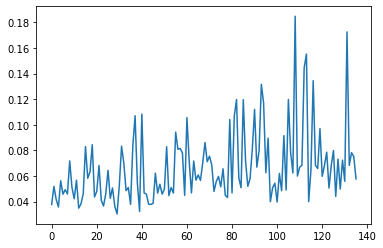

In [25]:
import matplotlib.pyplot as plt

if not skip_training:
    lr = 0.001
    epochs = 30
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    
    for epoch in range(epochs):
        running_loss = []
        for batch_num, training_batch in enumerate(trainloader):
            src, length, target = training_batch
            src = src.to(device)
            target = target.to(device)
            
            bs = src.shape[1]
            target_length = target.shape[0]
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            encoder_hidden = encoder.init_hidden(bs)
            encoder_output, encoder_hidden = encoder(src, length, encoder_hidden)
            
            decoder_hidden = encoder_hidden
            teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            
            decoder_input = target
            decoder_output, decoder_hidden = decoder(decoder_hidden, decoder_input, teacher_forcing)
            
            loss = 0
            for i in range(target_length):
                loss += F.nll_loss(decoder_output[i], target[i], ignore_index=PADDING_VALUE)
            loss = loss/target_length
            
            running_loss += [loss.item()]
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
        
        mean_tot_loss = np.mean(running_loss)
        print(f"epoch: {epoch + 1}, loss: {mean_tot_loss}")
    plt.plot(running_loss)

In [26]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '1_rnn_encoder.pth', confirm=True)
    tools.save_model(decoder, '1_rnn_decoder.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_rnn_encoder.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 1_rnn_decoder.pth.


In [27]:
if skip_training:
    hidden_size = 256
    encoder = Encoder(trainset.input_lang.n_words, embed_size, hidden_size)
    tools.load_model(encoder, '1_rnn_encoder.pth', device)
    
    decoder = Decoder(trainset.output_lang.n_words, embed_size, hidden_size)
    tools.load_model(decoder, '1_rnn_decoder.pth', device)

In [28]:
# This cell tests training accuracy

## Evaluation

Next we need to implement a function that converts input sequences to output sequences using the trained sequence-to-sequence model.

Notes:
* Since we do not need to compute the gradients in the evaluation phase, we can speed up the computations by using the statement `with torch.no_grad():`.
* Please transfer the tensors to `device` inside this function.

In [29]:
def translate(encoder, decoder, pad_src_seqs, src_seq_lengths):
    """Translate sequences from the source language to the target language using the trained model.
    
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      pad_src_seqs of shape (max_src_seq_length, batch_size): Padded source sequences.
      src_seq_lengths: List of source sequence lengths.
    
    Returns:
      out_seqs of shape (MAX_LENGTH, batch_size): LongTensor of word indices of the output sequences.
    """
    with torch.no_grad():
        bs = pad_src_seqs.shape[1]
        encoder_hidden = encoder.init_hidden(bs)
        encoder_output, encoder_hidden = encoder(pad_src_seqs, src_seq_lengths, encoder_hidden)
        decoder_hidden = encoder_hidden
        decoder_output, decoder_hidden = decoder(decoder_hidden)
        
        output = torch.Tensor()
        for i in range(decoder_output.shape[0]):
            topv, topi = decoder_output[i].data.topk(1) 
            output = torch.cat((output, topi.view(1,-1)), 0)

        return output

In [30]:
def test_translate_shapes():
    pad_src_seqs = torch.tensor([
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0]
    ])

    out_seqs = translate(encoder, decoder, pad_src_seqs, src_seq_lengths=[4, 2])
    assert out_seqs.shape == torch.Size([MAX_LENGTH, 2]), f"Wrong out_seqs.shape: {out_seqs.shape}"
    print('Success')

test_translate_shapes()

Success


Let us now translate a few sentences from the training set and print the source, target, and produced output.

If you trained the model well enough, the model should memorize the training data well.

In [31]:
def seq_to_tokens(seq, lang):
    'Convert a sequence of word indices into a list of words (strings).'
    sentence = []
    for i in seq:
        if i == EOS_token:
            break
        sentence.append(lang.index2word[i.item()])
    return(sentence)

def seq_to_string(seq, lang):
    'Convert a sequence of word indices into a sentence string.'
    return(' '.join(seq_to_tokens(seq, lang)))

In [32]:
# Translate a few sentences from the training set
print('Translate training data:')
print('-----------------------------')
pad_src_seqs, src_seq_lengths, pad_tgt_seqs = next(iter(trainloader))
out_seqs = translate(encoder, decoder, pad_src_seqs, src_seq_lengths)

for i in range(5):
    print('SRC:', seq_to_string(pad_src_seqs[:,i], trainset.input_lang))
    print('TGT:', seq_to_string(pad_tgt_seqs[:,i], trainset.output_lang))
    print('OUT:', seq_to_string(out_seqs[:,i], trainset.output_lang))
    print('')

Translate training data:
-----------------------------
SRC: il n est pas tout a fait la .
TGT: he s not all there .
OUT: he s not all there .

SRC: tu es deprimee n est ce pas ?
TGT: you re depressed aren t you ?
OUT: you re depressed aren t you ?

SRC: il n est pas vraiment le gerant .
TGT: he isn t actually the manager .
OUT: he isn t actually the manager .

SRC: je me trouve actuellement a l aeroport .
TGT: i m at the airport right now .
OUT: i m at the airport right now .

SRC: je ne vais pas garder cette chose .
TGT: i m not keeping this thing .
OUT: i m not keeping this thing .



Now we translate random sentences from the test set. A well-trained model should output sentences that look similar to the target ones. The mistakes are usually done for words that were rare in the training set.

In [33]:
testset = TranslationDataset(data_dir, train=False)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=True, collate_fn=collate)

In [34]:
print('Translate test data:')
print('-----------------------------')
pad_src_seqs, src_seq_lengths, pad_tgt_seqs = next(iter(testloader))
out_seqs = translate(encoder, decoder, pad_src_seqs, src_seq_lengths)

for i in range(5):
    print('SRC:', seq_to_string(pad_src_seqs[:,i], testset.input_lang))
    print('TGT:', seq_to_string(pad_tgt_seqs[:,i], testset.output_lang))
    print('OUT:', seq_to_string(out_seqs[:,i], testset.output_lang))
    print('')

Translate test data:
-----------------------------
SRC: classer les choses n est pas mon fort .
TGT: i m not good at classifying things .
OUT: he s not strong .

SRC: nous sommes faits l un pour l autre .
TGT: we re meant for each other .
OUT: we are liable for a for job .

SRC: je suis desolee de t ennuyer si souvent .
TGT: i m sorry to bother you so often .
OUT: i m sorry to bother you so often .

SRC: nous ne sommes pas ici pour t arreter .
TGT: we are not here to arrest you .
OUT: we are not here to arrest you .

SRC: vous etes tellement belle dans cette robe !
TGT: you re so beautiful in that dress .
OUT: you re so beautiful in that dress .



## Compute BLEU score

Let us now compute the [BLEU score](https://en.wikipedia.org/wiki/BLEU) for the translations produced by our model. We can use the PyTorch function [bleu_score](https://pytorch.org/text/data_metrics.html#torchtext.data.metrics.bleu_score) for that.

* **Our model should achieve a BLEU score of 95 on the training set.**
* The BLEU score on the test set can be significantly smaller (about 46).

The model can severly overfit to the training set and we do not cope with the overfitting problem in this exercise.

In [35]:
from torchtext.data.metrics import bleu_score

In [36]:
# Create translations for the training set
candidate_corpus = []
references_corpus = []
for pad_src_seqs, src_seq_lengths, pad_tgt_seqs in trainloader:
    out_seqs = translate(encoder, decoder, pad_src_seqs, src_seq_lengths)
    candidate_corpus.extend([seq_to_tokens(seq, trainset.output_lang) for seq in out_seqs.T])
    references_corpus.extend([[seq_to_tokens(seq, trainset.output_lang)] for seq in pad_tgt_seqs.T])

# Compute BLEU for translations
score = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score on training data: {score*100}')
assert score*100 > 90, "The BLEU score is too low."

BLEU score on training data: 96.47588729858398


In [37]:
# Create translations for the test set
candidate_corpus = []
references_corpus = []
for pad_src_seqs, src_seq_lengths, pad_tgt_seqs in testloader:
    out_seqs = translate(encoder, decoder, pad_src_seqs, src_seq_lengths)
    candidate_corpus.extend([seq_to_tokens(seq, testset.output_lang) for seq in out_seqs.T])
    references_corpus.extend([[seq_to_tokens(seq, testset.output_lang)] for seq in pad_tgt_seqs.T])

# Compute BLEU for translations
score = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score on test data: {score*100}')

BLEU score on test data: 47.706869442862136


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook:
* We learned how recurrent neural networks can be used to build a sequence-to-sequence model.
* We trained a sequence-to-sequence model for statistical machine translation.